In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [ ]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

In [40]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import itertools as it
import findspark
import random
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark_conf = SparkConf()\
  .setAppName("YourTestConf")\
  .setMaster("local[*]")\
  .set("spark.driver.maxResultSize", "8g")


sc = SparkContext.getOrCreate(spark_conf)

# spark = SparkSession.builder \
#         .appName("YourTest") \
#         .config("spark.driver.maxResultSize", "4g") \
#         .getOrCreate()

conf = SparkConf().setAppName("YourTest").set("spark.driver.maxResultSize", "4g")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
        

from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pyspark.sql.functions import col, udf, monotonically_increasing_id
from pyspark.sql.types import StringType, ArrayType
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pyspark.ml.feature import Tokenizer, StopWordsRemover, IDF, HashingTF, Normalizer, CountVectorizer, NGram, CountVectorizerModel
from pyspark.sql.types import MapType, StringType, ArrayType, IntegerType, BooleanType, StructType, StructField, DoubleType
from pyspark.ml.clustering import KMeans, LDA
from pyspark.ml import Pipeline

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

import datetime
import time 
from time import perf_counter
import gensim
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
from scipy.sparse import csr_matrix, vstack, save_npz, load_npz
from tqdm import tqdm
import scipy
import pickle

from pyspark.ml.linalg import SparseVector, VectorUDT


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
spark.conf.get('spark.driver.maxResultSize')

'4g'

In [4]:
spark

In [29]:
comments_df = (spark.read
      .option("multiline", "true")
      .option("quote", '"')
      .option("header", "true")
      .option("escape", "\\")
      .option("escape", '"')
      .csv("/content/drive/MyDrive/proj/uwaterloo_comments (1).csv")
).sample(0.01)

submissions_df = (spark.read
      .option("multiline", "true")
      .option("quote", '"')
      .option("header", "true")
      .option("escape", "\\")
      .option("escape", '"')
      .csv("/content/drive/MyDrive/proj/uwaterloo_submissions (1).csv")
).sample(0.1)

In [6]:
from pyspark.sql.functions import *

# ref_date = str(datetime.datetime(2012, 12, 31, 23, 59, 59))
ref_date = str(datetime.datetime(2013, 01, 31, 23, 59, 59))
# submissions_subset.withColumn('week', ceil(datediff('created_utc', lit(ref_date))/7))

submissions_subset = (submissions_df
    .filter((year(col("created_utc")) >= 2013) & (year(col("created_utc")) < 2023))
    .withColumn("text", concat_ws(' ', "selftext", "title"))
    .withColumn('week', ceil(datediff('created_utc', lit(ref_date))/7))
    .select("created_utc", "author", "text", "score", col('id').alias("link_id"), "week")
)

comments_subset = (comments_df.withColumn("created_utc", from_unixtime("created_utc"))
    .filter((year(col("created_utc")) >= 2013) & (year(col("created_utc")) < 2023))
    .withColumn("link_id", expr("substring(link_id, 4, length(link_id))"))
    .withColumn('week', ceil(datediff('created_utc', lit(ref_date))/7))
    .select("created_utc", "author", col('body').alias("text"), "score", "link_id", "week")
)

submissions_title = (submissions_df
    .filter((year(col("created_utc")) >= 2013) & (year(col("created_utc")) < 2023))
    .withColumn('week', ceil(datediff('created_utc', lit(ref_date))/7))
    .select("created_utc", "author", "title", "score", col('id').alias("title_link_id"), "week")
)


In [7]:
datetime.datetime(2012, 12, 31, 23, 59, 59) + datetime.timedelta(days=18*7)

datetime.datetime(2013, 5, 6, 23, 59, 59)

In [49]:
str(datetime.datetime(2013, 1, 1, 0, 0, 0))

'2013-01-01 00:00:00'

In [8]:
comments_subset.count(), submissions_subset.count()

(19163, 18215)

In [9]:
submissions_subset.columns, comments_subset.columns

(['created_utc', 'author', 'text', 'score', 'link_id', 'week'],
 ['created_utc', 'author', 'text', 'score', 'link_id', 'week'])

In [10]:
comments_subset.show(50)

+-------------------+-----------------+--------------------+-----+-------+----+
|        created_utc|           author|                text|score|link_id|week|
+-------------------+-----------------+--------------------+-----+-------+----+
|2013-01-05 05:04:12|       GramTheDon|Not up for debate...|    1| 15z42g|   1|
|2013-01-05 09:28:54|     NextBestSong|Second year Manag...|    4| 15zk64|   1|
|2013-01-10 09:50:17|      toggafrrupa|Why would you was...|    0| 16aohm|   2|
|2013-01-10 23:54:24|parahillObjective|I was just curiou...|    0| 169u9h|   2|
|2013-01-11 01:47:25|            nmost|sounds like that ...|    7| 16ce5h|   2|
|2013-01-13 19:40:49|       hippiechan|&gt; Protection w...|   -4| 16g17m|   2|
|2013-01-15 15:57:40|        [deleted]|Can recent grads ...|    2| 16g17m|   3|
|2013-01-18 03:35:29|         Enigmers|I was there (DDR ...|    2| 16silg|   3|
|2013-01-19 22:44:16|          NotDomo|Not to mention th...|    1| 16s0of|   3|
|2013-01-20 16:02:30|        [deleted]|I

In [11]:
df_concat = comments_subset.union(submissions_subset)
df_concat.cache()
df_concat.count()

37378

In [12]:
df_concat.show(5)

+-------------------+-----------------+--------------------+-----+-------+----+
|        created_utc|           author|                text|score|link_id|week|
+-------------------+-----------------+--------------------+-----+-------+----+
|2013-01-05 05:04:12|       GramTheDon|Not up for debate...|    1| 15z42g|   1|
|2013-01-05 09:28:54|     NextBestSong|Second year Manag...|    4| 15zk64|   1|
|2013-01-10 09:50:17|      toggafrrupa|Why would you was...|    0| 16aohm|   2|
|2013-01-10 23:54:24|parahillObjective|I was just curiou...|    0| 169u9h|   2|
|2013-01-11 01:47:25|            nmost|sounds like that ...|    7| 16ce5h|   2|
+-------------------+-----------------+--------------------+-----+-------+----+
only showing top 5 rows



In [13]:
import string, re

from tqdm import tqdm

_ = StopWordsRemover() 
stopwords = _.getStopWords()
stopwords_set = set(stopwords) | set(stop_words)  #| set(gazeteers)
print(len(stopwords_set))
non_space_whitespace = string.whitespace.replace(" ", "")

class CustomTokenizer(Tokenizer):
    def _transform(self, dataset):
        import string, re
        non_space_whitespace = string.whitespace.replace(" ", "")

        @udf(returnType=ArrayType(StringType()))
        def remove_punctuation_and_tokenize(text):
            if text is None:
              return []
            # Remove punctuation
            cleaned_text = text.lower().translate(str.maketrans('', '', string.punctuation))
            # cleaned_text = cleaned_text.translate(str.maketrans('', '', string.digits))
            cleaned_text = re.sub(f"[{non_space_whitespace}]", " ", cleaned_text)
            
            # Tokenize (split by whitespace)
            tokens = cleaned_text.split()
            
            return tokens
        
        return dataset.withColumn(self.getOutputCol(), remove_punctuation_and_tokenize(dataset[self.getInputCol()]))


# Create a custom StopWordsRemover with isalpha() filtering
class CustomStopWordsRemover(StopWordsRemover):
    def _transform(self, dataset):

        @udf(returnType=ArrayType(StringType()))
        def filter_words(words):
          filtered_tokens = []
          for w in words:
            if (w not in stopwords_set and 
                len(w) >= 1):
              filtered_tokens.append(w)
          if len(filtered_tokens) < 1:
            filtered_tokens.append('none')
          return filtered_tokens

        return dataset.withColumn(self.getOutputCol(), filter_words(dataset[self.getInputCol()]))
    

211


In [14]:
tokenizer = CustomTokenizer(inputCol="text", outputCol="tokens")
remover = CustomStopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
pipeline = Pipeline(stages=[tokenizer, remover])

In [15]:
# Fit the pipeline to the data
model = pipeline.fit(df_concat)

# Transform the data
processed_data = model.transform(df_concat)


In [16]:
processed_data.show(25, truncate=True)

+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+
|        created_utc|           author|                text|score|link_id|week|              tokens|     filtered_tokens|
+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+
|2013-01-05 05:04:12|       GramTheDon|Not up for debate...|    1| 15z42g|   1|[not, up, for, de...|[debate, post, re...|
|2013-01-05 09:28:54|     NextBestSong|Second year Manag...|    4| 15zk64|   1|[second, year, ma...|[second, year, ma...|
|2013-01-10 09:50:17|      toggafrrupa|Why would you was...|    0| 16aohm|   2|[why, would, you,...|[waste, time, eve...|
|2013-01-10 23:54:24|parahillObjective|I was just curiou...|    0| 169u9h|   2|[i, was, just, cu...|[curious, lol, di...|
|2013-01-11 01:47:25|            nmost|sounds like that ...|    7| 16ce5h|   2|[sounds, like, th...|[sounds, like, co...|
|2013-01-13 19:40:49|   

## Flatten tokens into lists per week and aggregate over each week since it's easier than groupby/aggregating sparse vectors per week

In [17]:
aggregated_processed_data = (processed_data
  .groupby('week')
  .agg(
      flatten(collect_list('filtered_tokens')).alias("filtered_tokens"),
      flatten(collect_list('tokens')).alias("unfiltered_tokens") 
  )
)


In [18]:
ngram = NGram(n=2, inputCol="unfiltered_tokens", outputCol="bigrams")
ngrams_df = ngram.transform(aggregated_processed_data)
ngrams_df = ngrams_df.withColumn("combined_uni_bigrams", concat(col("filtered_tokens"), col("bigrams")))
ngrams_df.show(5)


+----+--------------------+--------------------+--------------------+--------------------+
|week|     filtered_tokens|   unfiltered_tokens|             bigrams|combined_uni_bigrams|
+----+--------------------+--------------------+--------------------+--------------------+
|   1|[debate, post, re...|[not, up, for, de...|[not up, up for, ...|[debate, post, re...|
|   5|[thats, contract,...|[and, thats, beca...|[and thats, thats...|[thats, contract,...|
|   6|[goodbad, hard, c...|[how, goodbad, wa...|[how goodbad, goo...|[goodbad, hard, c...|
|   7|[uwaterloo, harle...|[uwaterloo, harle...|[uwaterloo harlem...|[uwaterloo, harle...|
|   9|[ive, taken, clas...|[ive, taken, clas...|[ive taken, taken...|[ive, taken, clas...|
+----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



## Loaded model

In [ ]:
!unzip Pyspark_CountVectorizer.zip

Archive:  Pyspark_CountVectorizer.zip
   creating: Pyspark_CountVectorizer/
  inflating: Pyspark_CountVectorizer/.DS_Store  
  inflating: __MACOSX/Pyspark_CountVectorizer/._.DS_Store  
   creating: Pyspark_CountVectorizer/metadata/
  inflating: Pyspark_CountVectorizer/metadata/_SUCCESS  
  inflating: __MACOSX/Pyspark_CountVectorizer/metadata/.__SUCCESS  
  inflating: Pyspark_CountVectorizer/metadata/part-00000  
  inflating: __MACOSX/Pyspark_CountVectorizer/metadata/._part-00000  


In [ ]:
!unzip Pyspark_Countvectorizer_model.zip

Archive:  Pyspark_Countvectorizer_model.zip
   creating: Pyspark_Countvectorizer_model/
   creating: Pyspark_Countvectorizer_model/data/
 extracting: Pyspark_Countvectorizer_model/data/._SUCCESS.crc  
  inflating: Pyspark_Countvectorizer_model/data/part-00000-6bdf42e5-cf7c-4dd7-8ec8-02b2a6846a1a-c000.snappy.parquet  
 extracting: Pyspark_Countvectorizer_model/data/.part-00000-6bdf42e5-cf7c-4dd7-8ec8-02b2a6846a1a-c000.snappy.parquet.crc  
 extracting: Pyspark_Countvectorizer_model/data/_SUCCESS  
   creating: Pyspark_Countvectorizer_model/metadata/
 extracting: Pyspark_Countvectorizer_model/metadata/._SUCCESS.crc  
 extracting: Pyspark_Countvectorizer_model/metadata/.part-00000.crc  
  inflating: Pyspark_Countvectorizer_model/metadata/part-00000  
 extracting: Pyspark_Countvectorizer_model/metadata/_SUCCESS  


In [ ]:
count_vectorizer = CountVectorizer.load("Pyspark_CountVectorizer")

model = CountVectorizerModel.load("Pyspark_Countvectorizer_model")


## Create model

In [20]:
2 ** 20

1048576

In [21]:
count_vectorizer = CountVectorizer(
    inputCol="combined_uni_bigrams",
    outputCol="raw_features",
    minDF=10,
    vocabSize=2 ** 20
)


In [22]:
model = count_vectorizer.fit(
    ngrams_df
)

# executed in 843 seconds

# with vocabSize 2 ** 18 and 0.1 sample of comment_df fitted in 74 s

# with vocabSize 2 ** 18 and 0.01 sample of comment_df and 0.1 of submissions_df fitted in  29s

## Transform model

In [23]:
vectorized_data = model.transform(ngrams_df)

In [24]:
vectorized_data.show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|week|     filtered_tokens|   unfiltered_tokens|             bigrams|combined_uni_bigrams|        raw_features|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|[debate, post, re...|[not, up, for, de...|[not up, up for, ...|[debate, post, re...|(20552,[3,4,5,7,8...|
|   5|[thats, contract,...|[and, thats, beca...|[and thats, thats...|[thats, contract,...|(20552,[0,3,4,7,8...|
|   6|[goodbad, hard, c...|[how, goodbad, wa...|[how goodbad, goo...|[goodbad, hard, c...|(20552,[0,1,2,3,4...|
|   7|[uwaterloo, harle...|[uwaterloo, harle...|[uwaterloo harlem...|[uwaterloo, harle...|(20552,[18,20,26,...|
|   9|[ive, taken, clas...|[ive, taken, clas...|[ive taken, taken...|[ive, taken, clas...|(20552,[0,1,2,4,5...|
+----+--------------------+--------------------+--------------------+--------------------+--------------

## Tokenize into bigrams for individual entries in order to be able to track individual link_id back from week-aggregated trends

In [25]:
ngram_original = NGram(n=2, inputCol="tokens", outputCol="comment_bigrams")
comment_ngrams_df = ngram_original.transform(processed_data)
comment_ngrams_df = comment_ngrams_df.withColumn("combined_uni_bigrams", concat(col("filtered_tokens"), col("comment_bigrams")))
comment_ngrams_df.show(5)

individual_level_vectorized_data = model.transform(comment_ngrams_df)
individual_level_vectorized_data.show(5)


+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+--------------------+--------------------+
|        created_utc|           author|                text|score|link_id|week|              tokens|     filtered_tokens|     comment_bigrams|combined_uni_bigrams|
+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+--------------------+--------------------+
|2013-01-05 05:04:12|       GramTheDon|Not up for debate...|    1| 15z42g|   1|[not, up, for, de...|[debate, post, re...|[not up, up for, ...|[debate, post, re...|
|2013-01-05 09:28:54|     NextBestSong|Second year Manag...|    4| 15zk64|   1|[second, year, ma...|[second, year, ma...|[second year, yea...|[second, year, ma...|
|2013-01-10 09:50:17|      toggafrrupa|Why would you was...|    0| 16aohm|   2|[why, would, you,...|[waste, time, eve...|[why would, would...|[waste, time, eve...|
|2013-01-10 23:5

## Save model

In [ ]:
model.getVocabSize()
count_vectorizer.save("Pyspark_CountVectorizer")

In [ ]:
model.save("Pyspark_Countvectorizer_model")


In [ ]:
!zip -r Pyspark_Countvectorizer_model.zip ./Pyspark_Countvectorizer_model/

  adding: Pyspark_Countvectorizer_model/ (stored 0%)
  adding: Pyspark_Countvectorizer_model/data/ (stored 0%)
  adding: Pyspark_Countvectorizer_model/data/._SUCCESS.crc (stored 0%)
  adding: Pyspark_Countvectorizer_model/data/part-00000-6bdf42e5-cf7c-4dd7-8ec8-02b2a6846a1a-c000.snappy.parquet (deflated 14%)
  adding: Pyspark_Countvectorizer_model/data/.part-00000-6bdf42e5-cf7c-4dd7-8ec8-02b2a6846a1a-c000.snappy.parquet.crc (stored 0%)
  adding: Pyspark_Countvectorizer_model/data/_SUCCESS (stored 0%)
  adding: Pyspark_Countvectorizer_model/metadata/ (stored 0%)
  adding: Pyspark_Countvectorizer_model/metadata/._SUCCESS.crc (stored 0%)
  adding: Pyspark_Countvectorizer_model/metadata/.part-00000.crc (stored 0%)
  adding: Pyspark_Countvectorizer_model/metadata/part-00000 (deflated 39%)
  adding: Pyspark_Countvectorizer_model/metadata/_SUCCESS (stored 0%)


## Continue

In [ ]:
model.getVocabSize(), len(model.vocabulary)
# data points for true vocabulary size: 143601, 20533, 

(1048576, 20619)

## Test countvectorizer

In [ ]:
from pyspark.ml.linalg import SparseVector

sv_1 = SparseVector(2 ** 18, [0,1,5], [1,2,10])
sv_2 = SparseVector(2 ** 18, [0,1,15], [3,4,11])

# def sparse_add(x, y):
import scipy.sparse as sps

# urNewVec = sps.csc_matrix(urOldVec) 
# urNewVec + urNewVec

# (sps.csc_matrix(sv_1) + sps.csc_matrix(sv_2))

sv_1

SparseVector(262144, {0: 1.0, 1: 2.0, 5: 10.0})

In [ ]:
%%timeit

# sv[0]['raw_features'] + sv[1]['raw_features']
(sps.csc_matrix(sv[0]['raw_features']) + sps.csc_matrix(sv[1]['raw_features']))

2.14 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
(sps.csr_matrix(sv[0]['raw_features']) + sps.csr_matrix(sv[1]['raw_features']))

2.1 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.stat import Summarizer


count_vectorizer_test = CountVectorizer(
    vocabSize=2 ** 18,
    inputCol="tokens",
    outputCol="features",
    minDF=3
)

schema = StructType([
    StructField("name", StringType(), True),
    StructField("text", StringType(), True),
])

# Create a list of data
data = [
    ("Alice", "this is document one one one one"),
    ("Bob", "this is document two one"),
    ("Charlie", "this is document three two"),
    ("David", "this is document four two")
]

@udf(returnType=(IntegerType()))
def count_tokens(c):
  return 1
        

test_df = spark.createDataFrame(data, schema=schema)

# count_vectorizer_test.fit(test_df)
test_ = tokenizer.transform(test_df)
m = count_vectorizer_test.fit(test_)
# m.show(5)
m_transformed = m.transform(test_)
# m.getVocabSize()
m_transformed = m_transformed.withColumn('weight', count_tokens(col('tokens')))
m_transformed.show(truncate=False)

m_transformed.select(Summarizer.normL1(m_transformed.features)).show()


+-------+--------------------------------+----------------------------------------+-------------------------------+------+
|name   |text                            |tokens                                  |features                       |weight|
+-------+--------------------------------+----------------------------------------+-------------------------------+------+
|Alice  |this is document one one one one|[this, is, document, one, one, one, one]|(4,[0,1,2],[1.0,1.0,1.0])      |1     |
|Bob    |this is document two one        |[this, is, document, two, one]          |(4,[0,1,2,3],[1.0,1.0,1.0,1.0])|1     |
|Charlie|this is document three two      |[this, is, document, three, two]        |(4,[0,1,2,3],[1.0,1.0,1.0,1.0])|1     |
|David  |this is document four two       |[this, is, document, four, two]         |(4,[0,1,2,3],[1.0,1.0,1.0,1.0])|1     |
+-------+--------------------------------+----------------------------------------+-------------------------------+------+

+--------------

In [ ]:
data = [(1, "Alice", 30), (2, "Bob", 28), (3, "Cathy", 35), (3, "Alice", 35), (3, "Alice", 28), (3, "Cathy", 35)]
columns = ["id", "name", "age"]
df = spark.createDataFrame(data, columns)


data_2 = []
columns_2 = ["id", "name", "age"]

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
])

df_2 = spark.createDataFrame(data_2, schema=schema)

df.groupBy('id', 'name').agg(sum('age')).show()
# df_2.union(df).show()

+---+-----+--------+
| id| name|sum(age)|
+---+-----+--------+
|  3|Cathy|      70|
|  2|  Bob|      28|
|  1|Alice|      30|
|  3|Alice|      63|
+---+-----+--------+



In [ ]:
df.show()

+---+-----+---+
| id| name|age|
+---+-----+---+
|  1|Alice| 30|
|  2|  Bob| 28|
|  3|Cathy| 35|
|  3|Alice| 35|
|  3|Alice| 28|
|  3|Cathy| 35|
+---+-----+---+



## Sort data

In [ ]:
sorted_vectorized_data.show(5)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|week|     filtered_tokens|   unfiltered_tokens|             bigrams|combined_uni_bigrams|        raw_features|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|[deleted, thing, ...|[deleted, the, th...|[deleted the, the...|[deleted, thing, ...|(143601,[0,1,2,3,...|
|   2|[friends, refused...|[i, had, friends,...|[i had, had frien...|[friends, refused...|(143601,[0,1,2,3,...|
|   3|[honest, found, c...|[to, be, honest, ...|[to be, be honest...|[honest, found, c...|(143601,[0,1,2,3,...|
|   4|[fluffer, brazzer...|[i, was, a, fluff...|[i was, was a, a ...|[fluffer, brazzer...|(143601,[0,1,2,3,...|
|   5|[heard, cecs, ask...|[i, once, heard, ...|[i once, once hea...|[heard, cecs, ask...|(143601,[0,1,2,3,...|
+----+--------------------+--------------------+--------------------+--------------------+--------------

In [ ]:
vectorized_data.select('raw_features').rdd.map(lambda x: x[0][3200]).sum()

724.0

## Use Summarizer's L1 norm to sum over all features in the sparsevector column raw_features, and define split_index to filter out elements that appear fewer than X times over all documents

In [26]:
from pyspark.ml.stat import Summarizer

MIN_COUNT_THRESHOLD = 200.0


sv = vectorized_data.select(Summarizer.normL1(vectorized_data.raw_features)).take(1)
split_index = np.where(sv[0]['normL1(raw_features)'].toArray() == MIN_COUNT_THRESHOLD)[0][-1]
print(split_index)

1094


In [27]:
@udf(returnType=VectorUDT())
def trim_sparse_vector(v, split_index):
  cutoff = np.where(v.indices > split_index)[0][0]
  v.indices = v.indices[:cutoff]
  v.values = v.values[:cutoff]
  v.size = split_index + 1
  return v


trimmed_vectors = vectorized_data.withColumn(
    "trimmed_features",
     trim_sparse_vector(col('raw_features'), lit(int(split_index)))
)

In [28]:
trimmed_vectors.show(10)

+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|week|     filtered_tokens|   unfiltered_tokens|             bigrams|combined_uni_bigrams|        raw_features|    trimmed_features|
+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   1|[debate, post, re...|[not, up, for, de...|[not up, up for, ...|[debate, post, re...|(20552,[3,4,5,7,8...|(1095,[3,4,5,7,8,...|
|   5|[thats, contract,...|[and, thats, beca...|[and thats, thats...|[thats, contract,...|(20552,[0,3,4,7,8...|(1095,[0,3,4,7,8,...|
|   6|[goodbad, hard, c...|[how, goodbad, wa...|[how goodbad, goo...|[goodbad, hard, c...|(20552,[0,1,2,3,4...|(1095,[0,1,2,3,4,...|
|   7|[uwaterloo, harle...|[uwaterloo, harle...|[uwaterloo harlem...|[uwaterloo, harle...|(20552,[18,20,26,...|(1095,[18,20,26,5...|
|   9|[ive, taken, clas...|[ive, taken, clas...|[ive taken, taken...|

In [ ]:
model.vocabulary[1089]

'year and'

In [ ]:
trimmed_vectors.select('trimmed_features').rdd.map(lambda x: x[0][4000]).sum()

In [ ]:
trimmed_vectors_limit = trimmed_vectors.select('week', 'trimmed_features').limit(10)

In [ ]:
trimmed_vectors_limit.show(10)

+----+--------------------+
|week|    trimmed_features|
+----+--------------------+
|  26|(143601,[0,1,2,3,...|
|  29|(143601,[0,1,2,3,...|
| 474|(143601,[0,1,2,3,...|
|  65|(143601,[0,1,2,3,...|
| 191|(143601,[0,1,2,3,...|
| 418|(143601,[0,1,2,3,...|
| 222|(143601,[0,1,2,3,...|
| 270|(143601,[0,1,2,3,...|
| 293|(143601,[0,1,2,3,...|
| 243|(143601,[0,1,2,3,...|
+----+--------------------+



## parallelize the columns of trimmed_features in pyspark and seasonal_compose on each

In [29]:
from pyspark.sql import Row

transformed_rdd = trimmed_vectors.rdd \
                                       .flatMap(lambda row: [(term_id, (row['week'], term_count)) for (term_id, term_count) in zip(row["trimmed_features"].indices, row["trimmed_features"].values)]) \
                                       .groupByKey() \
                                       .mapValues(lambda x: sorted(list(x), key=lambda y: y[0])) \
                                       .map(lambda x: (x[0], SparseVector(522 + 1, [i[0] for i in x[1]], [i[1] for i in x[1]])))



In [30]:
r = transformed_rdd.take(5)

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

def decompose_rdd(timeseries_sv, period=52, resid_std_threshold=5, min_counts=50):
  id = timeseries_sv[0]
  ts = timeseries_sv[1].toArray()[1:]
  sd = seasonal_decompose(ts, two_sided=False, model='additive', period=52)
  trend, seasonal, resid = sd.trend[~np.isnan(sd.trend)], sd.seasonal[~np.isnan(sd.seasonal)], sd.resid[~np.isnan(sd.resid)]

  sum_variances = np.var(trend) + np.var(seasonal) + np.var(resid)
  ratio_season = np.var(seasonal) / sum_variances
  ratio_trend = np.var(trend) / sum_variances
  ratio_resid = np.var(resid) / sum_variances

  mask = np.multiply((resid > (np.mean(resid) + resid_std_threshold * np.std(resid))), (resid > min_counts))

  return [id, np.where(mask)[0] + period + 1, ratio_season, ratio_trend, ratio_resid, timeseries_sv[1]]

decomposed_rdd = transformed_rdd.map(decompose_rdd)
decomposed_rdd_cache = decomposed_rdd.filter(lambda x: x[1].size > 0).cache()

In [32]:
r = decomposed_rdd_cache.take(10)

# id, where, ratio_season, ratio_trend, ratio_resid, week_1, week_2, week_3, ..., 

In [53]:
z = np.zeros(r[0][-1].size, dtype=np.int32)
for i in range(r[0][-1].size):
  z[i] = int(r[0][-1][i])

In [ ]:
r

In [54]:
decomposed_rdd_schema = StructType([
    StructField("term_id", IntegerType(), True),
    StructField("term_name", StringType(), True),
    StructField("peak_weeks", ArrayType(IntegerType()), True),
    StructField("ratio_season", DoubleType(), True),
    StructField("ratio_trend", DoubleType(), True),
    StructField("ratio_resid", DoubleType(), True),
    # StructField("", IntegerType(), True),
    *[StructField(f"week_{i}", IntegerType(), True) for i in range(523)]
])

In [ ]:


# Create a list of data
decomposed_rdd_data = []

for element in decomposed_rdd_cache.collect():
  z = [0] * element[-1].size
  for i in range(element[-1].size):
    z[i] = int(element[-1][i])

  decomposed_rdd_data.append((
      int(element[0]),
      str(model.vocabulary[element[0]]),
      element[1].tolist(), 
      float(element[2]), 
      float(element[3]), 
      float(element[4]), 
      *z
  ))

decomposed_rdd_df = spark.createDataFrame(
    decomposed_rdd_data,
    schema=decomposed_rdd_schema
)

In [67]:
1000 * 512

512000

In [77]:
decomposed_rdd_df.show()

+-------+---------+----------+------------------+-------------------+------------------+------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----

In [ ]:
weeks_expr = array([
    *[
        explode(array(
            lit(i), col(f"week_{i}")
        )).alias(f"week_{i}")
        for i in range(523)
    ]
])

In [ ]:
decomposed_rdd_df.select(
    col("term_id"),
    explode(weeks_expr).alias("count_per_week")
)


In [34]:
decomposed_rdd_df.rdd.getNumPartitions()

2

## Save rdds

In [79]:
current_timestamp = datetime.datetime.today().strftime("%m-%d-%Y-%H:%M:%S")
current_timestamp


'04-26-2023-02:58:21'

In [ ]:
# decomposed_rdd_cache.saveAsTextFile(f"/content/{current_timestamp}-decompose_results")
decomposed_rdd_df.write.parquet(f"/content/result-{current_timestamp}/EMR-results/decomposed_rdd_df.parquet") 


In [34]:
final_selected_terms = decomposed_rdd_cache.collect()

In [ ]:
final_selected_terms

## Up to here we get final desired terms for manual inspection -> proceed from here with a manual list of supplied terms

In [36]:
final_selected_terms_indices = list(map(lambda x: int(x[0]), final_selected_terms))[:3]
len(final_selected_terms_indices)

2

In [37]:
individual_level_vectorized_data.show(5)

+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|        created_utc|           author|                text|score|link_id|week|              tokens|     filtered_tokens|     comment_bigrams|combined_uni_bigrams|        raw_features|
+-------------------+-----------------+--------------------+-----+-------+----+--------------------+--------------------+--------------------+--------------------+--------------------+
|2013-01-05 05:04:12|       GramTheDon|Not up for debate...|    1| 15z42g|   1|[not, up, for, de...|[debate, post, re...|[not up, up for, ...|[debate, post, re...|(20552,[3,145,140...|
|2013-01-05 09:28:54|     NextBestSong|Second year Manag...|    4| 15zk64|   1|[second, year, ma...|[second, year, ma...|[second year, yea...|[second, year, ma...|(20552,[4,5,8,9,1...|
|2013-01-10 09:50:17|      toggafrrupa|Why would you was...|    0| 16aohm| 

In [ ]:
# final_selected_terms_indices = list(map(lambda x: lit(int(x)), final_selected_terms_indices))
# final_selected_terms_indices = list(map(lambda x: int(x), final_selected_terms_indices))

In [38]:
final_selected_terms_indices
# model.vocabulary[1005]

[14, 70]

In [ ]:
individual_level_vectorized_data.filter(
      find_in_sparse_vector(
          individual_level_vectorized_data["raw_features"],
          lit(int(term))
      )
  ).show(5)
# .groupBy('link_id').agg(count('*').alias('count'), count('author')).sort(col('count').desc()).show()
  # agg(count("*").alias("count")

In [44]:
from pyspark.sql.functions import expr


# @udf(returnType=IntegerType())
# def find_in_sparse_vector(v, *term_ids):
#   for id in term_ids:
#     if id in v.indices:
#       return id + 1
#   return 0

@udf(returnType=IntegerType())
def find_in_sparse_vector(v, term_id):
  if term_id in v.indices:
    return int(v[term_id])
  else:
    return 0

result_schema = StructType([
    StructField("agg_link_id", StringType(), True),
    StructField("num_occurrences_agg", IntegerType(), True),
    StructField("author", StringType(), True),
    StructField("title", StringType(), True),
    StructField("week", IntegerType(), True),
    StructField("term_id", IntegerType(), True),
    StructField("term", StringType(), True)
])


result_df = spark.createDataFrame([], schema=result_schema)
print(len(final_selected_terms_indices))

for term in final_selected_terms_indices:

  print(f"Term : {model.vocabulary[term]}, {term}")
  documents_containing_term = individual_level_vectorized_data \
    .withColumn(
        "num_occurrences", 
        find_in_sparse_vector(
            individual_level_vectorized_data["raw_features"],
            lit(int(term))
          )
    ) \
    .filter(col("num_occurrences") > 0) \
    .groupBy('link_id', 'week') \
    .agg(
        sum('num_occurrences').alias("num_occurrences_agg"), 
    ) \
    .withColumnRenamed("link_id", "agg_link_id") \
    .withColumnRenamed("week", "ind_week")

  final_df = documents_containing_term.join(submissions_title, documents_containing_term["agg_link_id"] == submissions_title["title_link_id"]) \
                    .select('agg_link_id', 'num_occurrences_agg', 'author', 'title', 'ind_week') \
                    .withColumn('term_id', lit(term)) \
                    .withColumn('term', lit(model.vocabulary[term]))
  # final_df = final_df \
  #   .groupBy('week') \
  #   .agg(
        
  #   )
  result_df = result_df.union(final_df)

# individual_level_vectorized_data.withColumn('term_id', find_in_sparse_vector(
#     individual_level_vectorized_data['raw_features'],
#     final_selected_terms_indices)
# )
result_df = result_df.cache()



2
Term : course, 14
Term : university, 70


In [ ]:
submissions_title.show(64)

In [76]:
documents_containing_term.show(5)

+-----------+--------+-------------------+
|agg_link_id|ind_week|num_occurrences_agg|
+-----------+--------+-------------------+
|     alg166|     318|                  1|
|     dyvygg|     360|                  1|
|     bdvvov|     329|                  1|
|     72d674|     247|                  1|
|     iu4j4q|     403|                  1|
+-----------+--------+-------------------+
only showing top 5 rows



In [ ]:
result_df.groupby('week').agg()

In [48]:
# week_index * 7 => entry is week_index => posted up to datetime.datetime(2012, 12, 31, 23, 59, 59) + datetime.timedelta(days=8*7)

print(datetime.datetime(2012, 12, 31, 23, 59, 59) + datetime.timedelta(days=(2 - 1)*7))

print(datetime.datetime(2012, 12, 31, 23, 59, 59) + datetime.timedelta(days=10*7))

2013-01-07 23:59:59
2013-03-11 23:59:59


In [ ]:
final_df.show()

In [45]:
result_df.show(100, truncate=False)

+-----------+-------------------+--------------------+-----------------------------------------------------------------------------------------------------------------+----+-------+------+
|agg_link_id|num_occurrences_agg|author              |title                                                                                                            |week|term_id|term  |
+-----------+-------------------+--------------------+-----------------------------------------------------------------------------------------------------------------+----+-------+------+
|165mte     |3                  |SantiClaws          |Is anyone enrolled in RS110 or any online course?                                                                |2   |14     |course|
|17pzbc     |4                  |Joukkainen          |PSA: LEARN will package all the files for a course in one zip file for easy download                             |5   |14     |course|
|1bivfp     |2                  |sxvanhelden         |S

In [80]:
# f_name = model.vocabulary[final_selected_terms_indices[0]]
current_timestamp

result_df.coalesce(1).write.csv(
    f"/content/{current_timestamp}-joined_results",
    mode="overwrite",
    header=True,
    sep=",",
    quote='"',
    escapeQuotes=True,
    escape='"',
    quoteAll=True,
    encoding="utf-8",
    emptyValue="None",
    nullValue="",
    timestampFormat="yyyy-MM-dd'T'HH:mm:ss",
)

In [81]:
current_timestamp

'04-26-2023-02:58:21'

In [53]:
result_df.write.parquet(f"/content/result-{current_timestamp}/EMR-results/emr-result-join.parquet") 

In [82]:
fname = f"result-{current_timestamp}"
fname

'result-04-26-2023-02:58:21'

In [83]:
!zip -r emr-result.zip ./{fname}/

	zip warning: name not matched: ./result-04-26-2023-02:58:21/

zip error: Nothing to do! (try: zip -r emr-result.zip . -i ./result-04-26-2023-02:58:21/)


In [35]:
comments_df = spark.read.option("header","true").option("recursiveFileLookup","true").parquet("/content/aaaaa")

In [36]:
comments_df.dtypes

[('link_id', 'string'),
 ('distinguished', 'string'),
 ('id', 'string'),
 ('author_flair_css_class', 'string'),
 ('parent_id', 'string'),
 ('ups', 'int'),
 ('created_utc', 'int'),
 ('subreddit', 'string'),
 ('author_flair_text', 'string'),
 ('score', 'int'),
 ('author', 'string'),
 ('controversiality', 'int'),
 ('subreddit_id', 'string'),
 ('body', 'string'),
 ('gilded', 'int'),
 ('edited', 'boolean')]

In [32]:
submissions_df = spark.read.option("header","true").option("recursiveFileLookup","true").parquet("/content/bbb")


In [39]:
(submissions_df.withColumn("created_utc", from_unixtime("created_utc"))
        .filter((year(col("created_utc")) >= 2013) & (year(col("created_utc")) < 2023))
        .withColumn("text", concat_ws(' ', "selftext", "title"))
        .withColumn('week', ceil(datediff('created_utc', lit(REF_DATE))/7))
        .select("created_utc", "author", "text", "score", col('id').alias("link_id"), "week")
    ).show(5)

+-------------------+---------------+--------------------+-----+-------+----+
|        created_utc|         author|                text|score|link_id|week|
+-------------------+---------------+--------------------+-----+-------+----+
|2017-06-10 19:23:25|        cowow0w|I tried the searc...|    9| 6gh1uv| 232|
|2017-06-10 20:25:05|deartutorialtas|Post your advice ...|   21| 6ghdxg| 232|
|2017-06-10 21:04:17|frustratedguyuw|I applied to 50 j...|    8| 6ghlgi| 232|
|2017-06-10 21:20:43|      [deleted]| [deleted] Geomatics|    0| 6ghole| 232|
|2017-06-10 22:13:48|     uwRANTSTFU|is this a major r...|    5| 6ghydb| 232|
+-------------------+---------------+--------------------+-----+-------+----+
only showing top 5 rows



In [19]:
from pyspark.sql.functions import *
REF_DATE = str(datetime.datetime(2013, 1, 1, 0, 0, 0))
(submissions_df
        .withColumn("created_utc", from_unixtime("created_utc")) 
        .filter((year(col("created_utc")) >= 2013) & (year(col("created_utc")) < 2023))
        .withColumn("text", concat_ws(' ', "selftext", "title"))
        .withColumn('week', ceil(datediff('created_utc', lit(REF_DATE))/7))
        .select("created_utc", "author", "text", "score", col('id').alias("link_id"), "week")
    ).show(5)

+-------------------+---------------+--------------------+-----+-------+----+
|        created_utc|         author|                text|score|link_id|week|
+-------------------+---------------+--------------------+-----+-------+----+
|2017-06-10 19:23:25|        cowow0w|I tried the searc...|    9| 6gh1uv| 232|
|2017-06-10 20:25:05|deartutorialtas|Post your advice ...|   21| 6ghdxg| 232|
|2017-06-10 21:04:17|frustratedguyuw|I applied to 50 j...|    8| 6ghlgi| 232|
|2017-06-10 21:20:43|      [deleted]| [deleted] Geomatics|    0| 6ghole| 232|
|2017-06-10 22:13:48|     uwRANTSTFU|is this a major r...|    5| 6ghydb| 232|
+-------------------+---------------+--------------------+-----+-------+----+
only showing top 5 rows



In [ ]:
final_selected_terms = decomposed_rdd.filter(lambda x: x[1].size > 0).collect()

In [ ]:
model.vocabulary[selected[6][0]]

'crncr'

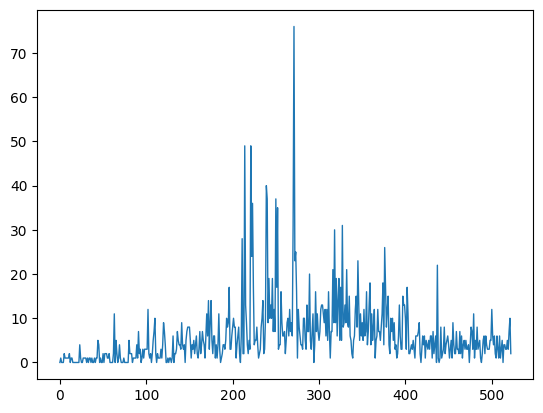

In [ ]:
plt.plot(selected[9][5][1].toArray(), linewidth=1)

In [52]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Create a custom StopWordsRemover with isalpha() filtering
class CustomStopWordsRemover(StopWordsRemover):
    
    def pp(self):
      return self.getStopWords()

    def _transform(self, dataset):

        @udf(returnType=ArrayType(StringType()))
        def filter_words(words):
          filtered_tokens = []
          for w in words:
            if (w not in stopwords_set and 
                len(w) >= 1):
              filtered_tokens.append(w)
          if len(filtered_tokens) < 1:
            filtered_tokens.append('none')
          return filtered_tokens

        return dataset.withColumn(self.getOutputCol(), filter_words(dataset[self.getInputCol()]))

cswr = CustomStopWordsRemover()


In [55]:
print(list(set(stop_words) | set(cswr.pp())))

['is', 'herself', 'will', "he'll", 'shan', 'do', 'against', 'doesn', "doesn't", "i'm", 'just', 'and', 'with', "you've", 'm', 'he', 'into', 'no', "here's", "who's", 'won', "they're", 'our', 'both', 'most', 'her', 'such', 'she', 'mustn', 'before', 'themselves', 'yourselves', 'can', 'in', 'during', 'were', 'his', "she'll", 'on', 'nor', 'would', "didn't", 'hers', 'll', 'being', 'did', "that'll", "she's", 'any', 'few', "where's", 'your', 'a', "needn't", 'am', 'should', "you'll", 'yours', 'then', 'out', 'above', 'there', 'which', "why's", 'has', 'too', 'under', 'until', 'their', 's', 'who', "can't", 'only', "they'll", "you're", 'shouldn', 'why', 'the', 'or', 'up', 'my', 'ma', 'having', "i'd", 'each', 'himself', 'was', "isn't", "weren't", 'same', 'than', "shouldn't", "there's", 'haven', "haven't", 're', 'ourselves', 'about', "mustn't", 'wasn', 'through', 'by', "he's", 'its', "we'll", "when's", "what's", "they'd", 'are', 'more', "hasn't", 'itself', "i'll", 'other', 'here', 'from', 'they', "don

In [3]:
s = '''
Term : like, 0
Term : year, 27
Term : every, 135
Term : fall, 324
Term : penis, 378
Term : the time, 432
Term : the university, 513
Term : ampx200b, 594
Term : international, 621
Term : system, 675
Term : back to, 810
Term : ive been, 864
Term : thread, 918
Term : to talk, 1026
Term : r, 1107
Term : 101, 1161
Term : the exam, 1242
Term : god, 1296
Term : letter, 1620
Term : gym, 1674
Term : of waterloo, 1728
Term : awesome, 1755
Term : cases, 1782
Term : to cs, 1971
Term : got in, 2511
Term : article, 2754
Term : i say, 3024
Term : freedom, 3321
Term : jesus, 4806
Term : cancel, 5211
Term : shut down, 9612
Term : introduction to, 11718
Term : academic mission, 16470
Term : yes yes, 11313
Term : gucci, 18171
Term : been taking, 20115
Term : saudi, 21843
Term : pronouns, 25515
Term : nonwhite, 22464
Term : hamster, 36126
Term : sus, 16065
Term : discomfort, 31347
Term : jr, 31455
Term : nices, 26217
Term : got, 28
Term : fuck, 109
Term : out of, 190
Term : man, 325
Term : times, 379
Term : you know, 406
Term : mark, 595
Term : position, 649
Term : just a, 676
Term : club, 811
Term : the world, 1081
Term : mentioned, 1189
Term : ppl, 1432
Term : increase, 1891
Term : ta, 1918
Term : this sub, 1972
Term : event, 2080
Term : media, 2269
Term : eyes, 3025
Term : adjustment, 3484
Term : art, 3538
Term : shut up, 4996
Term : honk, 5725
Term : csbba, 5968
Term : wd, 6454
Term : the fucking, 7318
Term : math 137, 7507
Term : deferred to, 10207
Term : adhd, 12313
Term : protests, 13015
Term : at facebook, 14284
Term : spring 2020, 14527
Term : dave, 11638
Term : suicide, 3349
Term : hong kong, 9181
Term : optin, 10936
Term : waitlist, 11827
Term : palestinian, 27298
Term : courses mentioned, 33697
Term : dont, 2
Term : term, 29
Term : u, 110
Term : interview, 245
Term : mr, 326
Term : i feel, 407
Term : mr goose, 434
Term : ur, 488
Term : on campus, 515
Term : regarding, 542
Term : difficult, 596
Term : mental, 677
Term : amp, 704
Term : offers, 758
Term : pick, 974
Term : of you, 1136
Term : sent, 1163
Term : double, 1244
Term : sound, 1379
Term : games, 1622
Term : stress, 1649
Term : and your, 1730
Term : state, 1892
Term : syde, 2054
Term : factor, 2108
Term : college, 2378
Term : taking a, 2540
Term : land, 2621
Term : ranking, 2945
Term : piazza, 3269
Term : fall term, 3674
Term : which one, 3728
Term : the police, 3890
Term : a post, 4754
Term : israel, 6266
Term : rch, 8399
Term : things out, 14771
Term : ͡° ͜ʖ, 3107
Term : alarm, 7238
Term : jews, 9857
Term : worked there, 9884
Term : indigenous, 11693
Term : like studying, 4403
Term : guys if, 27002
Term : facebook in, 34184
Term : 0 0, 27785
Term : cerb, 17687
Term : course, 30
Term : thanks, 84
Term : questions, 111
Term : campus, 165
Term : on a, 354
Term : i do, 435
Term : name, 543
Term : interest, 1056
Term : meme, 1326
Term : human, 1542
Term : history, 1596
Term : following, 1731
Term : vote, 1839
Term : raise, 2217
Term : matched, 3081
Term : council, 3324
Term : teacher, 3621
Term : cancelled, 3864
Term : the spring, 3891
Term : property, 4107
Term : scholarships, 4188
Term : downvote, 5403
Term : probability, 6942
Term : flu, 8373
Term : the vaccine, 10425
Term : councillors, 12612
Term : rain, 12720
Term : remindme, 20604
Term : intelligence, 6240
Term : velocity, 9075
Term : continuous, 2325
Term : uwaterlooca, 14907
Term : head get, 22764
Term : coronavirus, 11154
Term : gucci gang, 31404
Term : ive, 58
Term : help, 85
Term : if i, 166
Term : jobs, 193
Term : you need, 220
Term : guys, 274
Term : some of, 436
Term : number, 490
Term : today, 517
Term : situation, 544
Term : 12, 625
Term : problems, 652
Term : good luck, 706
Term : tuition, 733
Term : pass, 760
Term : to pay, 922
Term : government, 976
Term : sleep, 1003
Term : upper, 1300
Term : language, 1327
Term : e, 1354
Term : key, 1624
Term : rejected, 1786
Term : meal, 2056
Term : die, 2218
Term : 2019, 2731
Term : french, 3028
Term : geomatics, 3325
Term : sexual, 3487
Term : 😂, 3541
Term : brother, 3973
Term : flex, 4459
Term : fuck up, 4945
Term : pop, 6376
Term : gained, 10615
Term : the meeting, 14206
Term : vaccination, 15259
Term : israeli, 16474
Term : open in, 19282
Term : monopoly, 28462
Term : bike, 2380
Term : voting, 5323
Term : kw4rent, 4891
Term : a3, 21307
Term : need, 32
Term : said, 113
Term : and you, 329
Term : literally, 356
Term : month, 572
Term : women, 680
Term : per, 761
Term : hate, 788
Term : worse, 923
Term : in canada, 977
Term : service, 1139
Term : admission, 1220
Term : majority, 1517
Term : story, 1571
Term : welcome, 1598
Term : society, 1652
Term : you did, 1679
Term : resources, 1760
Term : parking, 1922
Term : cs and, 2057
Term : evidence, 2516
Term : cute, 2597
Term : ib, 2759
Term : flair, 3245
Term : blue, 5162
Term : actsc, 7214
Term : matches, 7349
Term : harassment, 8888
Term : cr, 12641
Term : dat, 13370
Term : ottawa, 4838
Term : alert, 13019
Term : paninos, 6998
Term : suicides, 16664
Term : muslim, 8321
Term : defund, 23036
Term : ei, 33836
Term : supremacy, 19283
Term : cs, 33
Term : made, 195
Term : of my, 222
Term : goose, 276
Term : problem, 303
Term : can be, 330
Term : thank mr, 546
Term : to know, 573
Term : computer, 654
Term : support, 708
Term : leave, 735
Term : add, 762
Term : toronto, 789
Term : we have, 843
Term : bus, 1005
Term : country, 1086
Term : join, 1140
Term : sub, 1194
Term : response, 1248
Term : if we, 2031
Term : v1, 2085
Term : ideas, 2166
Term : what im, 3273
Term : applicant, 4029
Term : cs coop, 5001
Term : porn, 6918
Term : content of, 14532
Term : of toronto, 15153
Term : say so, 16233
Term : about right, 17043
Term : western, 2841
Term : ͜ʖ, 3030
Term : minority, 4920
Term : anth, 30192
Term : a yes, 37509
Term : hk, 9726
Term : booster, 13695
Term : at fb, 33702
Term : fuck pd, 465
Term : goose thank, 2193
Term : just shut, 20040
Term : shit, 142
Term : pay, 196
Term : email, 250
Term : message, 439
Term : for your, 520
Term : academic, 574
Term : has been, 817
Term : feeling, 952
Term : walk, 1060
Term : uoft, 1114
Term : head, 1168
Term : covid, 1222
Term : he was, 1357
Term : morning, 1546
Term : power, 1681
Term : score, 1924
Term : fam, 2113
Term : to transfer, 2329
Term : petition, 2545
Term : tier, 4516
Term : dr, 5137
Term : okay to, 9106
Term : coke, 17071
Term : 💯, 18151
Term : feds, 1249
Term : false, 3787
Term : shitposts, 7405
Term : abortions, 29383
Term : tattoo, 15532
Term : ukraine, 23416
Term : welcome youre, 15073
Term : students, 35
Term : yes, 143
Term : to go, 251
Term : little, 305
Term : canada, 359
Term : software, 386
Term : major, 494
Term : resume, 521
Term : consider, 548
Term : the program, 1007
Term : in cs, 1115
Term : video, 1142
Term : three, 1277
Term : black, 1358
Term : cover, 1439
Term : teaching, 1466
Term : policy, 1547
Term : racist, 1736
Term : news, 1871
Term : theory, 1952
Term : congrats, 2276
Term : shitpost, 2708
Term : meat, 4220
Term : ama, 5381
Term : rape, 5867
Term : the academic, 6974
Term : mission, 8216
Term : the response, 9080
Term : russian, 11861
Term : well all, 23498
Term : analyzing, 23876
Term : debate, 5030
Term : removed removed, 6029
Term : psychologists, 12806
Term : raped, 15290
Term : motion, 9377
Term : kanye, 22715
Term : redacted, 15074
Term : please, 90
Term : engineering, 144
Term : will be, 171
Term : luck, 414
Term : the school, 1035
Term : game, 1089
Term : there’s, 1278
Term : joke, 1494
Term : a day, 1737
Term : 2020, 2007
Term : ecs, 2196
Term : plans, 2709
Term : get out, 2925
Term : scholarship, 3708
Term : 137, 3816
Term : spread, 3897
Term : weather, 3924
Term : not taking, 4977
Term : grt, 5112
Term : trap, 8244
Term : climate, 8892
Term : my heart, 9918
Term : homeless, 5652
Term : blm, 22527
Term : nine, 27387
Term : there right, 24444
Term : iran, 29034
Term : by user, 4707
Term : taking, 172
Term : love, 334
Term : op, 388
Term : because i, 442
Term : right now, 496
Term : given, 631
Term : option, 658
Term : notes, 712
Term : application, 847
Term : arts, 955
Term : break, 982
Term : waiting, 1414
Term : feel free, 1738
Term : friday, 1981
Term : 136, 2143
Term : alright, 2170
Term : funding, 2359
Term : political, 2467
Term : into cs, 2845
Term : children, 3142
Term : energy, 3439
Term : accepted to, 5518
Term : lives, 2197
Term : delete, 3115
Term : child, 3736
Term : responsibility, 4087
Term : draw, 5140
Term : wholesome, 6679
Term : the chinese, 6895
Term : gun, 8191
Term : suicidal, 8893
Term : crncr, 12538
Term : chinese people, 13051
Term : nude, 20206
Term : 25th, 24580
Term : virus, 4060
Term : adjustment factor, 6490
Term : program, 92
Term : class, 119
Term : person, 173
Term : side, 362
Term : ece, 470
Term : past, 497
Term : idk, 605
Term : transfer, 686
Term : stat, 956
Term : paying, 983
Term : can’t, 1064
Term : decision, 1145
Term : btw, 1361
Term : cali, 1388
Term : thats what, 1739
Term : board, 1766
Term : dont feel, 2306
Term : discussion, 2441
Term : travel, 3089
Term : i worked, 3359
Term : cheating, 3575
Term : trump, 3791
Term : farm, 4439
Term : alumni, 4655
Term : so my, 5195
Term : we know, 5438
Term : cover letter, 6761
Term : movement, 7895
Term : im talking, 8570
Term : advocacy, 10649
Term : ties, 11135
'''

len(s.split('\n'))

455

In [ ]:
bb

In [ ]:
from pyspark.sql.types import MapType, StringType, ArrayType, IntegerType, BooleanType

def sparse_vector_to_dict(sparse_vector):
    return {int(index): int(value) for index, value in zip(sparse_vector.indices, sparse_vector.values)}

sparse_vector_to_dict_udf = udf(sparse_vector_to_dict, MapType(IntegerType(), IntegerType()))


In [ ]:
processed_data.withColumn("word_frequencies", sparse_vector_to_dict_udf(processed_data.raw_features)).show(5)

In [ ]:
from pyspark.sql.functions import sum as sql_sum, col
from pyspark.ml.linalg import SparseVector, VectorUDT

def sparse_to_dict(sparse: SparseVector):
    return dict(zip(sparse.indices, sparse.values))


def agg_sparse(x: SparseVector, y: SparseVector):
    if x.size != y.size:
        raise ValueError("Dimensions of sparse vectors must match.")
    x_dict, y_dict = sparse_to_dict(x), sparse_to_dict(y)
    merged = {k: x_dict.get(k, 0) + y_dict.get(k, 0) for k in set(x_dict) | set(y_dict)}
    return SparseVector(x.size, merged)

@udf(returnType=VectorUDT())
def sparse_sum(vectors):
    res = None
    for vec in vectors:
        if res is None:
            res = vec
        else:
            res = agg_sparse(vec,res)
    return res

(processed_data.groupBy("week")
      .agg(collect_list('raw_features').alias('vectors'))
      .withColumn("merged_vector", sparse_sum("vectors"))
    # .agg(merge_sparse_vectors_udf(col("raw_features"))
    # .alias("merged_sparse_vector"))
).sort("week").show(5)
# (processed_data
#  .withColumn("word_frequencies", sparse_vector_to_dict_udf(processed_data.raw_features))
#  .groupBy("week")
#  .agg(sql_sum(col("word_frequencies")))
# ).show(5)





ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
{int(index): int(value) for index, value in zip(raw_features[1][0].indices, raw_features[1][0].values)}

{13: 1, 16: 1, 691: 1, 715: 1, 1279: 1}

In [ ]:
from pyspark.mllib.linalg import SparseVector

sv = SparseVector(2 ** 18, {})
sv.indices[0] = 0

IndexError: ignored